In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import ipyvolume as ipv
import ipywidgets as widgets
#from matplotlib import interactive
#interactive(True)
#%matplotlib notebook 
#%matplotlib qt

from IPython.display import display, Math, Latex


import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import detector2
import re
import pickle
import dill

from pymoo.algorithms.nsga2 import NSGA2
from pymoo.model.problem import Problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.factory import get_visualization, get_decomposition
from pymoo.util.display import Display

from pymoo.factory import get_performance_indicator
from pymoo.performance_indicator.hv import Hypervolume

from pymoo.factory import get_decision_making, get_reference_directions
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create detector geometry and simulate tracks  

The module detector creates a simple 2D geometry of a wire based tracker made by 4 planes.

The adjustable parameters are the radius of each wire, the pitch (along the y axis), and the shift along y and z of a plane with respect to the previous one. 

A total of 8 parameters can be tuned. 

The goal of this toy model, is to tune the detector design so to optimize the efficiency (fraction of tracks which are detected) as well as the cost for its realization. As a proxy for the cost, we use the material/volume (the surface in 2D) of the detector. For a track to be detetected, in the efficiency definition we require at least two wires hit by the track. 

So we want to maximize the efficiency (defined in detector.py) and minimize the cost. 

#### LIST OF PARAMETERS
(baseline values)
* R = .5   [cm]
* pitch = 10.0  [cm]
* y1 = 0.0, y2 = 0.0, y3 = 0.0, z1 = 2.0, z2 = 4.0, z3 = 6.0 [cm]


::::: BASELINE PARAMETERS :::::
R, pitch, y1, y2, y3, z1, z2, z3:  0.5 10.0 0.0 0.0 0.0 2.0 4.0 6.0 

:::: INITIAL GEOMETRY ::::


<IPython.core.display.Javascript object>


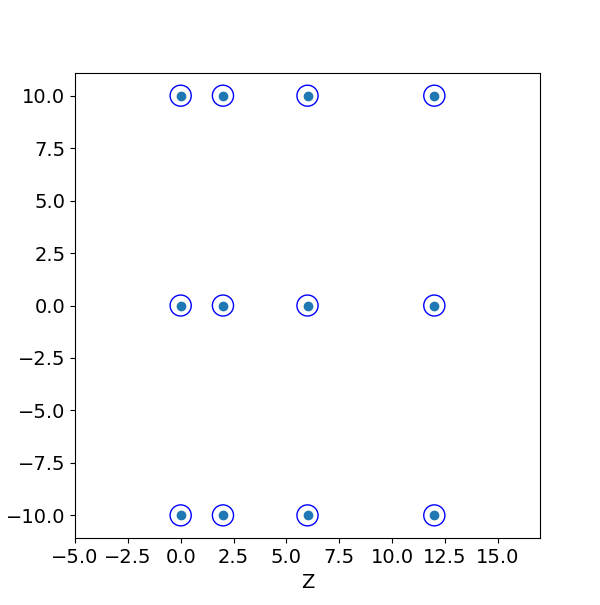

# of wires:  12 , volume:  37.68
:::: TRACK GENERATION ::::


<IPython.core.display.Javascript object>


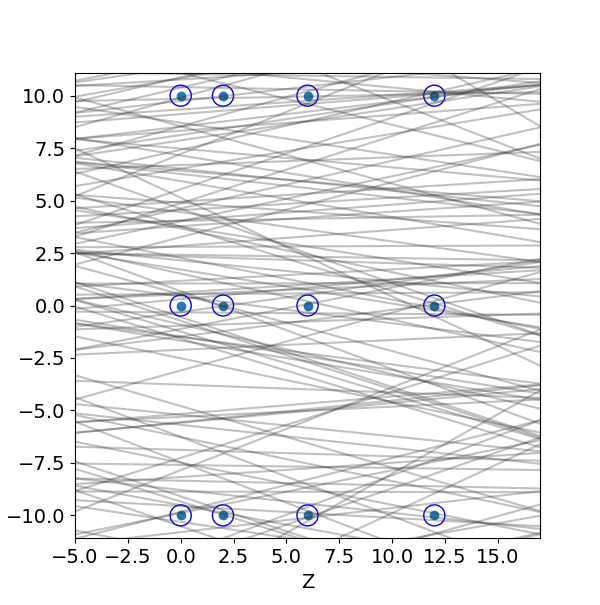

fraction of tracks detected:  0.092


In [8]:
# CONSTANT PARAMETERS
#------ define mother region ------#
y_min=-10.1
y_max=10.1

print("::::: BASELINE PARAMETERS :::::")
R = .5  
pitch = 10.0  
y1 = 0.0
y2 = 0.0
y3 = 0.0
z1 = 2.0
z2 = 4.0
z3 = 6.0

print("R, pitch, y1, y2, y3, z1, z2, z3: ", R, pitch, y1, y2, y3, z1, z2, z3,"\n")


#------------- GEOMETRY ---------------#
print(":::: INITIAL GEOMETRY ::::")
tr = detector2.Tracker(R, pitch, y1, y2, y3, z1, z2, z3)
Z, Y = tr.create_geometry()
num_wires = detector2.calculate_wires(Y, y_min, y_max)

volume = detector2.wires_volume(Y, y_min, y_max,R)

detector2.geometry_display(Z, Y, R, y_min=y_min, y_max=y_max,block=False,pause=5) #5

print("# of wires: ", num_wires, ", volume: ", volume)

#------------- TRACK GENERATION -----------#
print(":::: TRACK GENERATION ::::")
N_tracks = 1000
t = detector2.Tracks(b_min=-100, b_max=100, alpha_mean=0, alpha_std=0.2)
tracks = t.generate(N_tracks)

detector2.geometry_display(Z, Y, R, y_min=y_min, y_max=y_max,block=False, pause=-1)
detector2.tracks_display(tracks, Z,block=False,pause=5)

 #a track is detected if at least two wires have been hit
score = detector2.get_score(Z, Y, tracks, R)
frac_detected = score[0]
print("fraction of tracks detected: ",frac_detected)



### Define Objectives 

Defines a class for the objectives of the problem that can be used in the MOO.  

In [9]:

class objectives():

  def __init__(self,tracks,y_min,y_max):
    self.tracks = tracks
    self.y_min = y_min
    self.y_max = y_max

  def wrapper_geometry(fun):

      def inner(self):
          R, pitch, y1, y2, y3, z1, z2, z3 = self.X
          self.geometry(R, pitch, y1, y2, y3, z1, z2, z3)
          return fun(self)
      return inner

  def update_tracks(self, new_tracks):
    self.tracks = new_tracks

  def update_design_point(self,X):
      self.X = X


  def geometry(self,R, pitch, y1, y2, y3, z1, z2, z3):
    tr = detector2.Tracker(R, pitch, y1, y2, y3, z1, z2, z3)
    self.R = R
    self.Z, self.Y = tr.create_geometry()


  @wrapper_geometry
  def calc_score(self):
      res = detector2.get_score(self.Z, self.Y, self.tracks, self.R)
      assert res[0] >= 0 and res[1] >= 0,"Fraction or Resolution negative."
      
      return res

  
  def get_score(self,X):
    R, pitch, y1, y2, y3, z1, z2, z3 = X
    self.geometry(R, pitch, y1, y2, y3, z1, z2, z3)
    res = detector2.get_score(self.Z, self.Y, self.tracks, self.R)
    return res
  

  def get_volume(self):
    volume = detector2.wires_volume(self.Y, self.y_min, self.y_max,self.R)
    return volume



res = objectives(tracks,y_min,y_max)

#res.geometry(R, pitch, y1, y2, y3, z1, z2, z3)

X = R, pitch, y1, y2, y3, z1, z2, z3
#fscore  = res.get_score(X)
res.update_design_point(X)
fscore  = res.calc_score()[0]
fvolume = res.get_volume()

print("...check: ", fvolume, fscore)



...check:  37.68 0.092



# Multi-Objective Optimization

We will be using pymoo (https://pymoo.org/getting_started.html).  

* In the constructor method we specify number of variables N, objectives M, and constraint functions, as well as the lower and upper boundaries of each variable. In our toy model, these boundaries are taken in such a way that all solutions are feasible and no constraint function is needed. You can try to change this and introduce some constraint. 



* The *_evaluate* method takes a one-dimensional NumPy array x number of entries equal to n_var. This behavior is enabled by setting *elementwise_evaluation=True* while calling the super() method. 

* Notice that every function is minimized. Our efficiency is defined as an tracking inefficiency = 1 - efficiency




In [10]:
class MyProblem(Problem):

    #--------- vectorized ---------#

    def __init__(self):
        super().__init__(n_var=8,
                         n_obj=2,
                         n_constr=0,
                         xl=np.array([0.5,2.5,0.,0.,0.,2.,2.,2.]),
                         xu=np.array([1.0,5.0,4.,4.,4.,10.,10.,10.]),elementwise_evaluation=True)

    def _evaluate(self, x, out, *args, **kwargs):


        f1 = 1.-res.get_score(x)[0] 
        f2 = res.get_volume()

        #if you had constraints
        #g1 = gu1(x)
        #g2 = gu2(x), etc. 

        out["F"] = [f1, f2]
        #out["G"] = [g1, g2, ...]



### Creation of Problem and choice of optimization algorithm. 


* We will use NSGA-II, as explained in the lectures. You can decide the population size and the number of offsprings, based on what we discussed. 


* Pymoo offers different algorithms that can be used which are highly customizable and can be easily extended.
https://pymoo.org/algorithms/index.html


* Before dealing with a problem, it's useful to compare with a list of test problems reported in https://pymoo.org/problems/index.html, where different scenarios in terms of Variables, Objectives, Constraints are described. 



In [11]:
class MyDisplay(Display):

    def _do(self, problem, evaluator, algorithm):
        super()._do(problem, evaluator, algorithm)
        self.output.append("<X>", np.mean(algorithm.pop.get("X")))
        self.output.append("<f1>", np.mean(algorithm.pop.get("F")[:,0]))
        self.output.append("<f2>", np.mean(algorithm.pop.get("F")[:,1]))


problem = MyProblem()



algorithm = NSGA2(pop_size=100,n_offsprings=20) 


res = minimize(problem,
               algorithm,
               ("n_gen", 100),
               verbose=True,
               seed=1,
               display=MyDisplay(),
               save_history=True)

n_gen |  n_eval |     <X>      |     <f1>     |     <f2>    
    1 |     100 |  3.574631175 |  0.461100000 |  1.62169E+02
    2 |     120 |  3.568837541 |  0.443690000 |  1.59785E+02
    3 |     140 |  3.546999418 |  0.448790000 |  1.53812E+02
    4 |     160 |  3.527723670 |  0.453910000 |  1.49534E+02
    5 |     180 |  3.581771507 |  0.450730000 |  1.47617E+02
    6 |     200 |  3.529721498 |  0.448730000 |  1.45423E+02
    7 |     220 |  3.540122585 |  0.437510000 |  1.47995E+02
    8 |     240 |  3.543313024 |  0.411940000 |  1.55125E+02
    9 |     260 |  3.520021809 |  0.416970000 |  1.53606E+02
   10 |     280 |  3.516828710 |  0.415280000 |  1.51950E+02
   11 |     300 |  3.535422980 |  0.397100000 |  1.57706E+02
   12 |     320 |  3.577686196 |  0.386800000 |  1.60720E+02
   13 |     340 |  3.612701166 |  0.369440000 |  1.68630E+02
   14 |     360 |  3.625927571 |  0.369790000 |  1.67302E+02
   15 |     380 |  3.606456127 |  0.380980000 |  1.60289E+02
   16 |     400 |  3.574


### Comments:

You can change what to display during the generations following: http://pymoo.org/interface/display.html

Above:
* n_gen: # of generations  
* n_eval: # of evaluations. In the first generation the population is created. Then at each iteration, we create new offsprings.   
* n_nds: # of non dominated solutions        
* indicator: all solutions are feasible within the provided ranges. No constraint violations expected (you can check this). 


res.F, res.X allow to display the Pareto front (in the objective space) and set (in the design space)   

## Analysis of Results 

<IPython.core.display.Javascript object>


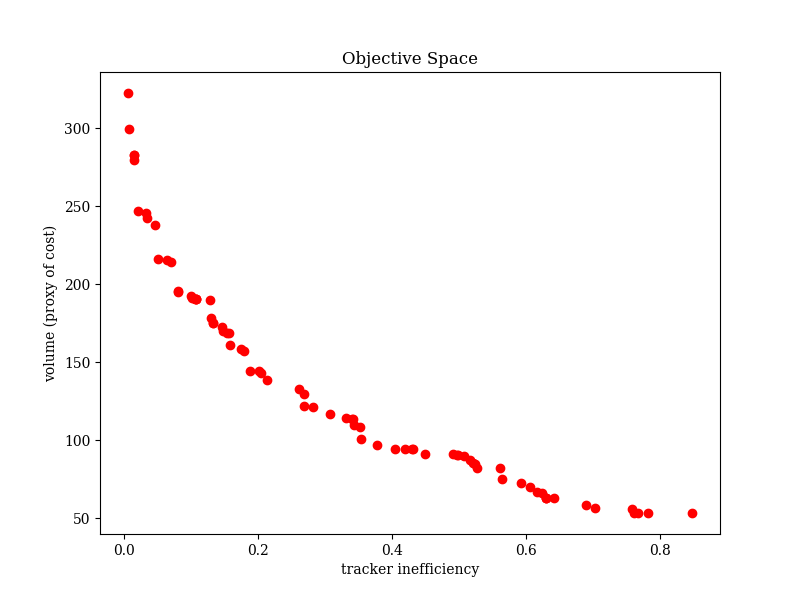

In [12]:
plot = Scatter(labels=["tracker inefficiency","volume (proxy of cost)"], title = "Objective Space")
plot.add(res.F, color="red")
plot.show()

### Comments: 


# Post-processing: Metrics and Decision Making  

In [13]:

#-----------------------------------#
#          Post-Processing          #
#-----------------------------------#
#------------------------------------------------------------------------------#

n_evals = []    # corresponding number of function evaluations\
F = []          # the objective space values in each generation
cv = []         # constraint violation in each generation


# iterate over the deepcopies of algorithms
for algorithm in res.history:

    # store the number of function evaluations
    n_evals.append(algorithm.evaluator.n_eval)

    # retrieve the optimum from the algorithm
    opt = algorithm.opt

    # store the least contraint violation in this generation (in case this happens)
    cv.append(opt.get("CV").min())

    # filter out only the feasible and append
    feas = np.where(opt.get("feasible"))[0]
    _F = opt.get("F")[feas]
    F.append(_F)




<IPython.core.display.Javascript object>


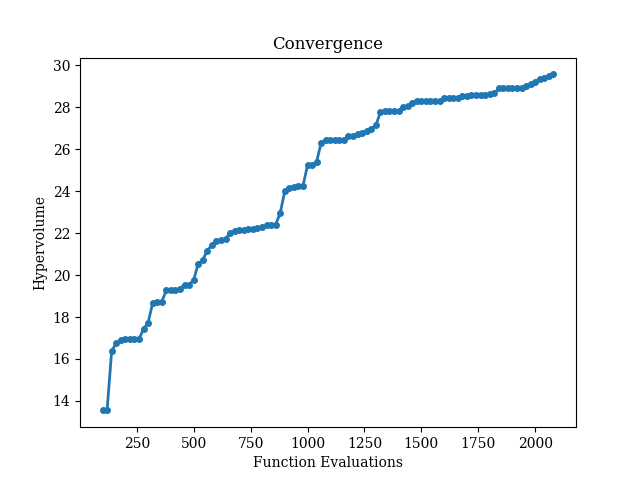

In [14]:
#-----------------------------------#
#              Metrics              #
#-----------------------------------#
#------------------------------------------------------------------------------#

# MODIFY - this is problem dependent: 
# you can choose any reasonable reference point and calculate the hypervolume with respect to that point. 
ref_point = np.array([0.5, 200])

# create the performance indicator object with reference point
metric = Hypervolume(ref_point=ref_point, normalize=False)


# calculate for each generation the HV metric
hv = [metric.calc(f) for f in F]  #or res.F

plt.figure() 
# visualize the convergence curve
plt.plot(n_evals, hv, '-o', markersize=4, linewidth=2)
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()



# Decision Making 

The obtained trade-off Pareto solutions can be assigned a pseudo-weight (on each direction of the objexctive space, the pseudo-weight will range in [0,1]) where (1,0) means small f1 (x) and large f2 (y).

The values of the pseudo-weights will depend on the position of the points on the Pareto front

After a pseudo-weight is assigned to each solution, the one closer to the decision maker's wish may be selected.

For details, see  https://arxiv.org/pdf/2002.04504.pdf




In [15]:

weights_a = np.array([0., 0.])
a, pseudo_weights_a = get_decision_making("pseudo-weights", weights_a).do(res.F, return_pseudo_weights=True)

weights_b = np.array([0.5, 0.5])
b, pseudo_weights_b = get_decision_making("pseudo-weights", weights_b).do(res.F, return_pseudo_weights=True)

weights_c = np.array([1.0, 1.0])
c, pseudo_weights_c = get_decision_making("pseudo-weights", weights_c).do(res.F, return_pseudo_weights=True)



print(a)
print(b)
print(res.F[a])
print(res.F[[a,b]])


print("...weights: ", weights_a)
#print("...pseudo_weights: ", pseudo_weights_a)
X_par = res.X
idx_opt = a
X_opt = X_par[idx_opt, :]
print("...solution and objectives")
print(X_opt)
print(res.F[idx_opt])

print("")

print("...weights: ", weights_b)
#print("...pseudo_weights: ", pseudo_weights_b)
idx_opt = b
X_opt = X_par[idx_opt, :]
print("...solution and objectives")
print(X_opt)
print(res.F[idx_opt])

print("")

print("...weights: ", weights_c)
#print("...pseudo_weights: ", pseudo_weights_c)
idx_opt = c
X_opt = X_par[idx_opt, :]
print("...solution and objectives")
print(X_opt)
print(res.F[idx_opt])

1
62
[ 0.624      66.13190388]
[[  0.624       66.13190388]
 [  0.261      133.20458156]]
...weights:  [0. 0.]
...solution and objectives
[0.51309253 3.60258904 0.43245387 2.56484861 3.86802099 4.33848658
 8.92858805 4.74167194]
[ 0.624      66.13190388]

...weights:  [0.5 0.5]
...solution and objectives
[0.59457156 2.57821202 1.52918665 3.57280772 1.62372603 2.30809311
 2.06307592 2.12743334]
[  0.261      133.20458156]

...weights:  [1. 1.]
...solution and objectives
[0.56811651 2.53379754 1.38616617 3.68151473 1.59245361 2.70025093
 7.43564817 2.69340156]
[  0.282      121.61460176]
